In [33]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

from scipy import signal

from sklearn.metrics import roc_curve, auc, f1_score, classification_report, accuracy_score
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
import tensorflow as tf

from keras import layers, models, regularizers   # Import models here
from keras.metrics import MeanSquaredError
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, TimeDistributed
from keras.regularizers import l2



In [25]:
print(f"PyTorch version: {torch.__version__}")


PyTorch version: 2.3.0+cu121


In [40]:
background = np.load('Datasets/background.npz')['data']
bbh = np.load('Datasets/bbh_for_challenge.npy')
sglf = np.load('Datasets/sglf_for_challenge.npy')


In [41]:
background.shape, bbh.shape, sglf.shape

((100000, 2, 200), (100000, 2, 200), (100000, 2, 200))

In [42]:
print(background.shape)

(100000, 2, 200)


# RNN 

In [43]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history
def eval_metric(model, history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, NB_START_EPOCHS + 1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    print()
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results
    
def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)
def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
    '''
    Function to compare a metric between two models 
    
    Parameters:
        model_hist_1 : training history of model 1
        model_hist_2 : training history of model 2
        metrix : metric to compare, loss, acc, val_loss or val_acc
        
    Output:
        plot of metrics of both models
    '''
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]
    e = range(1, NB_START_EPOCHS + 1)
    
    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }
    
    metric_label = metrics_dict[metric]
    plt.plot(e, metric_model_1, 'bo', label=model_1.name)
    plt.plot(e, metric_model_2, 'b', label=model_2.name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()
    
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

In [44]:
# Transpose the data to have shape (samples, time_steps, features)
background = background.transpose(0, 2, 1)  # Shape: (100000, 200, 2)
bbh = bbh.transpose(0, 2, 1)  # Shape: (100000, 200, 2)
sglf = sglf.transpose(0, 2, 1)  # Shape: (100000, 200, 2)

# Normalize data (optional, based on your dataset characteristics)
background = background / np.max(background)
bbh = bbh / np.max(bbh)
sglf = sglf / np.max(sglf)

# Split background into training and validation sets
X_train, X_val = train_test_split(background, test_size=0.2, random_state=42)


In [45]:
# Model parameters
time_steps = 200  # Number of time steps (per segment)
features = 2      # Number of features (Hanford & Livingston streams)
latent_dim = 32   # Latent dimension for compressed representation

# Encoder
input_seq = Input(shape=(time_steps, features))
encoded = SimpleRNN(
    64, 
    activation='tanh', 
    return_sequences=False,  # Compress the entire sequence into one vector
    kernel_regularizer=l2(0.01), 
    recurrent_regularizer=l2(0.01), 
    recurrent_dropout=0.2
)(input_seq)
encoded = Dropout(0.3)(encoded)

# Latent Space
latent = Dense(latent_dim, activation='relu', kernel_regularizer=l2(0.01))(encoded)

# Decoder
decoded = RepeatVector(time_steps)(latent)  # Repeat latent vector for each time step
decoded = SimpleRNN(
    64, 
    activation='tanh', 
    return_sequences=True, 
    kernel_regularizer=l2(0.01), 
    recurrent_regularizer=l2(0.01), 
    recurrent_dropout=0.2
)(decoded)
decoded = Dropout(0.3)(decoded)
decoded = TimeDistributed(Dense(features, activation='sigmoid'))(decoded)  # Match input feature dimension

# Autoencoder Model
autoencoder = Model(inputs=input_seq, outputs=decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Summary of the model
autoencoder.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 200, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_12 (SimpleRNN)       │ (None, 64)             │         4,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 200, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_13 (SimpleRNN)       │ (None, 200, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 200, 2)         │           130 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,706 (49.63 KB)

 Trainable params: 12,706 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
history = autoencoder.fit(
    X_train, X_train,  # Input and target are the same for reconstruction
    validation_data=(X_val, X_val),
    epochs=20,          # Adjust based on convergence
    batch_size=64,      # Batch size (experiment with values like 32 or 128)
    shuffle=True
)


Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 161s 59ms/step - accuracy: 0.4999 - loss: 0.7903 - val_accuracy: 0.4999 - val_loss: 0.0065
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 76s 26ms/step - accuracy: 0.4997 - loss: 0.0024 - val_accuracy: 0.4999 - val_loss: 4.8441e-05
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.5000 - loss: 5.6940e-05 - val_accuracy: 0.4999 - val_loss: 3.5440e-05
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.4999 - loss: 3.9741e-05 - val_accuracy: 0.4999 - val_loss: 3.2962e-05
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.5002 - loss: 3.5400e-05 - val_accuracy: 0.4999 - val_loss: 3.2180e-05
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.5002 - loss: 3.3755e-05 - val_accuracy: 0.4999 - val_loss: 3.1890e-05
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.4999 - loss: 3.2729e-05 - val_accuracy: 0.4999 - val_loss: 3.1772e-05
Epoch 8/20
1250/1250 ━━━━━━━━━━

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step


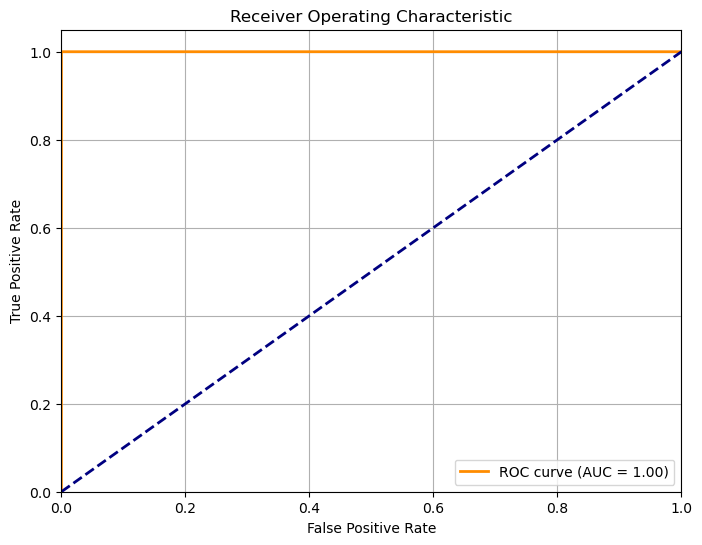

In [48]:
def create_roc_curve(autoencoder, background, anomalies):
    """
    Create and plot an ROC curve for the autoencoder model based on reconstruction error.

    Parameters:
    - autoencoder: Trained autoencoder model.
    - background: Normal data used to train the autoencoder.
    - anomalies: Anomalous data to test the model (could be bbh, sglf, etc.)

    Returns:
    - None
    """
    # Step 1: Calculate reconstruction error for the normal (background) data
    X_background_reconstructed = autoencoder.predict(background)
    background_error = np.mean(np.square(background - X_background_reconstructed), axis=(1, 2))

    # Step 2: Calculate reconstruction error for the anomalies
    X_anomalies_reconstructed = autoencoder.predict(anomalies)
    anomaly_error = np.mean(np.square(anomalies - X_anomalies_reconstructed), axis=(1, 2))

    # Step 3: Combine the errors and create labels
    errors = np.concatenate([background_error, anomaly_error])
    labels = np.concatenate([np.zeros(len(background_error)), np.ones(len(anomaly_error))])

    # Step 4: Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(labels, errors)
    roc_auc = auc(fpr, tpr)

    # Step 5: Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Example usage
# Assuming the `autoencoder` is already trained, and `background`, `bbh`, and `sglf` are prepared datasets:
create_roc_curve(autoencoder, background, bbh)  # You can also try sglf or other anomalous datasets



In [34]:
# Model parameters
time_steps = 200  # Number of time steps (per segment)
features = 2      # Number of features (Hanford & Livingston streams)

# Build the RNN model
# Build the RNN model with regularization
model = Sequential([
    SimpleRNN(
        64, 
        activation='tanh', 
        return_sequences=True, 
        input_shape=(time_steps, features),
        kernel_regularizer=l2(0.01),   # L2 regularization on weights
        recurrent_regularizer=l2(0.01),  # L2 regularization on recurrent connections
        recurrent_dropout=0.2          # Recurrent dropout
    ),
    Dropout(0.3),  # Increased dropout rate for better regularization
    SimpleRNN(
        32, 
        activation='tanh', 
        return_sequences=True, 
        kernel_regularizer=l2(0.01),
        recurrent_regularizer=l2(0.01),
        recurrent_dropout=0.2
    ),
    Dropout(0.3),
    TimeDistributed(Dense(
        2, 
        activation='sigmoid',  # For binary outputs, use sigmoid activation
        kernel_regularizer=l2(0.01)  # Regularization in output layer
    ))
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [35]:
# Reconstruction-based training
model.compile(optimizer='adam', loss='mse')  # Mean squared error for reconstruction
history = model.fit(background, background, epochs=20, batch_size=64, validation_split=0.2)


Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7926

KeyboardInterrupt: 

In [11]:
bbh_reconstructed = model.predict(bbh)


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step


In [13]:
reconstruction_errors = np.mean(np.square(bbh - bbh_reconstructed), axis=(1, 2))  # Error per sample
reconstruction_errors

array([0.0002901 , 0.00027461, 0.00021704, ..., 0.00031527, 0.00022854,
       0.00030269])

In [14]:
background_reconstructed = model.predict(background)
background_errors = np.mean(np.square(background - background_reconstructed), axis=(1, 2))


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step


In [15]:
threshold = np.percentile(background_errors, 95)  # 95th percentile as the anomaly threshold
anomalies = reconstruction_errors > threshold
anomalies

array([False, False, False, ..., False, False, False])

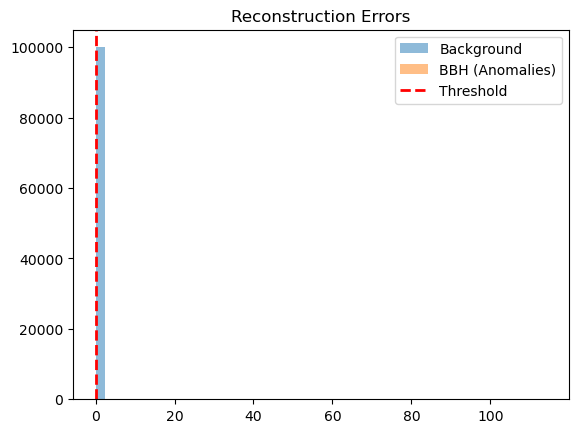

In [22]:
plt.hist(background_errors, bins=50, alpha=0.5, label='Background')
plt.hist(reconstruction_errors, bins=50, alpha=0.5, label='BBH (Anomalies)')
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
plt.legend()
plt.title('Reconstruction Errors')
plt.show()


In [33]:
def get_image(data, num_input): 
    multi_seg_data_0 = np.array([])
    for i in range(num_input):
        multi_seg_data_0 = np.concatenate((multi_seg_data_0, data[i][0]), axis=0)
    multi_seg_data_0.shape
    
    multi_seg_data_1 = np.array([])
    for i in range(num_input):
        multi_seg_data_1 = np.concatenate((multi_seg_data_1, data[i][1]), axis=0)
    multi_seg_data_1.shape
    return [multi_seg_data_0, multi_seg_data_1]
    
def draw_image(multi_seg_data):
    f, t, Sxx = signal.spectrogram(multi_seg_data, fs=4096)
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]');
    

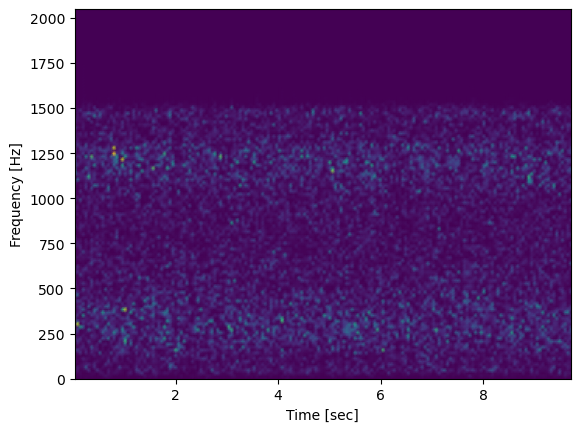

In [34]:
draw_image(get_image(background, 200)[0])

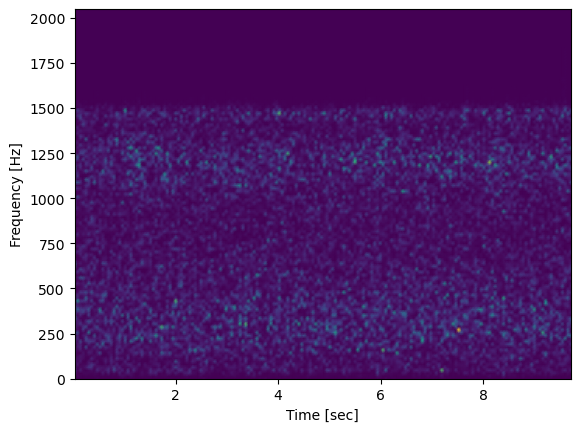

In [36]:
draw_image(get_image(background, 200)[1])

In [37]:
background

array([[[ 0.91269977,  0.82407612,  0.5769567 , ...,  0.20686445,
         -0.27786226,  0.15823164],
        [-1.25096175, -0.95855157,  0.94997294, ...,  0.82529191,
          0.40796463, -0.21042227]],

       [[ 0.42714055,  0.12621982, -0.16199408, ..., -0.5175994 ,
          0.02568501,  0.96384967],
        [-0.02978683, -0.15513659, -0.32712013, ...,  0.13461775,
          1.40842105,  0.11178541]],

       [[-0.08685232, -0.25764326,  0.28607773, ...,  0.12621982,
         -0.16199408,  0.40371295],
        [-0.61207828, -0.46881478,  0.0829569 , ..., -0.15513659,
         -0.32712013, -0.19736512]],

       ...,

       [[ 0.71059816,  0.72778956, -0.3071292 , ..., -0.63907715,
         -0.21119135,  0.12864316],
        [-0.8691844 ,  0.11999158,  0.42448763, ...,  1.04059958,
          0.34299788, -0.0331056 ]],

       [[ 0.75439799, -0.02600797, -0.35126296, ..., -0.21351791,
         -0.05497888, -0.10111759],
        [-0.67076066, -1.27768468, -0.49526618, ..., -0.83186

# CNN 

In [5]:
# Transpose the datasets to match the required shape (N, 200, 2)
background = background.transpose(0, 2, 1)  # Shape: (100000, 200, 2)
bbh = bbh.transpose(0, 2, 1)                # Shape: (100000, 200, 2)
sglf = sglf.transpose(0, 2, 1)              # Shape: (100000, 200, 2)

# Combine datasets
X = np.concatenate([background, bbh, sglf], axis=0)  # Shape: (300000, 200, 2)

# Create labels: 0 for background, 1 for BBH, 2 for SGJF
y = np.concatenate([
    np.zeros(background.shape[0], dtype=int),  # Shape: (100000,)
    np.ones(bbh.shape[0], dtype=int),          # Shape: (100000,)
    np.full(sglf.shape[0], 2, dtype=int)       # Shape: (100000,)
])

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training set into training (90%) and validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=3)





In [12]:
from tensorflow.keras import layers, models, regularizers

input_shape = (200, 2)

model = models.Sequential([
    layers.Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=input_shape, 
                  kernel_regularizer=regularizers.l2(0.2)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', 
                  kernel_regularizer=regularizers.l2(0.2)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', 
                  kernel_regularizer=regularizers.l2(0.2)),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    # Change the output layer to softmax for multi-class classification
    layers.Dense(3, activation='softmax')  # 3 classes: background, BBH, SGJF
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'mse'])

# Print the model summary
model.summary()


/opt/conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 198, 16)        │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 99, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 97, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 48, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 46, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1472)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       188,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 196,819 (768.82 KB)

 Trainable params: 196,819 (768.82 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
early_stopping = EarlyStopping(
    monitor='val_loss',      # Monitor the validation loss
    patience=5,              # Stop after 5 epochs of no improvement
    restore_best_weights=True # Restore the best weights when stopping
)

# Train the model with early stopping
history = model.fit(
    X_train, y_train_one_hot,
    validation_data=(X_val, y_val_one_hot),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping] # Include the early stopping callback
)

Epoch 1/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8074 - loss: 1.9745 - mse: 0.0983 - val_accuracy: 0.8784 - val_loss: 0.6605 - val_mse: 0.0604
Epoch 2/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8947 - loss: 0.6136 - mse: 0.0551 - val_accuracy: 0.9182 - val_loss: 0.5238 - val_mse: 0.0447
Epoch 3/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9012 - loss: 0.5450 - mse: 0.0508 - val_accuracy: 0.9214 - val_loss: 0.4731 - val_mse: 0.0402
Epoch 4/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9079 - loss: 0.4998 - mse: 0.0470 - val_accuracy: 0.9130 - val_loss: 0.4613 - val_mse: 0.0421
Epoch 5/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9127 - loss: 0.4742 - mse: 0.0448 - val_accuracy: 0.9352 - val_loss: 0.4155 - val_mse: 0.0339
Epoch 6/20
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9160 - loss: 0.4543 - mse: 0.0430 - val_accuracy: 0.9404 - val_loss: 0.4079 - val_mse: 0.0334
Epoch 7/20
 662/3375 ━━

KeyboardInterrupt: 

In [ ]:
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=3)# Evaluate the model with one-hot encoded labels
test_loss, test_accuracy, test_mse = model.evaluate(X_test, y_test_one_hot)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test MSE: {test_mse}")


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_multiclass(model, X_test, y_test, class_labels):
    """
    Plots the ROC curve for a multi-class classification model.
    
    Parameters:
    - model: Trained Keras model.
    - X_test: Test data (features).
    - y_test: Test data (labels).
    - class_labels: List of class labels.
    """
    # Binarize the labels for multi-class ROC curve computation
    y_test_bin = label_binarize(y_test, classes=range(len(class_labels)))
    
    # Get the predicted probabilities for each class
    y_score = model.predict(X_test)
    
    # Compute ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot the ROC curves
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(class_labels):
        plt.plot(fpr[i], tpr[i], label=f"Class {label} (AUC = {roc_auc[i]:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.title("ROC Curve for Multi-Class Classification", fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

# Example usage:
class_labels = ['Background', 'BBH', 'SGJF']
plot_roc_multiclass(model, X_test, y_test, class_labels)


In [25]:
y_pred_prob = model.predict(X_test)  # Get predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

f1_macro = f1_score(y_test, y_pred, average='macro')  # Macro F1 score
f1_weighted = f1_score(y_test, y_pred, average='weighted')  # Weighted F1 score
f1_per_class = f1_score(y_test, y_pred, average=None)  # F1 score per class

print("Macro F1 Score:", f1_macro)
print("Weighted F1 Score:", f1_weighted)
print("F1 Score per Class:", f1_per_class)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 880us/step
Macro F1 Score: 0.6895172165642999
Weighted F1 Score: 0.6890974915442465
F1 Score per Class: [0.92718225 0.55113075 0.59023865]
